In [1]:
!pip install pennylane
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.7 MB/s eta 0:00:00


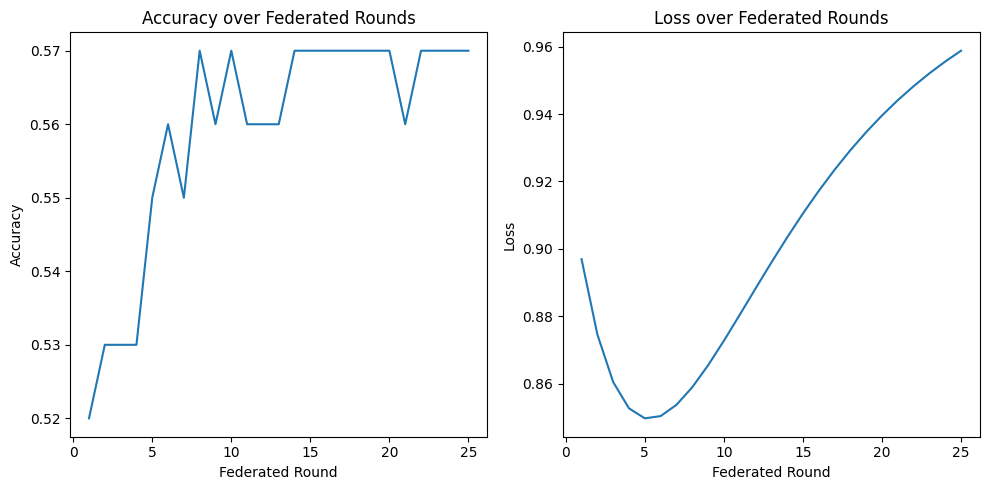

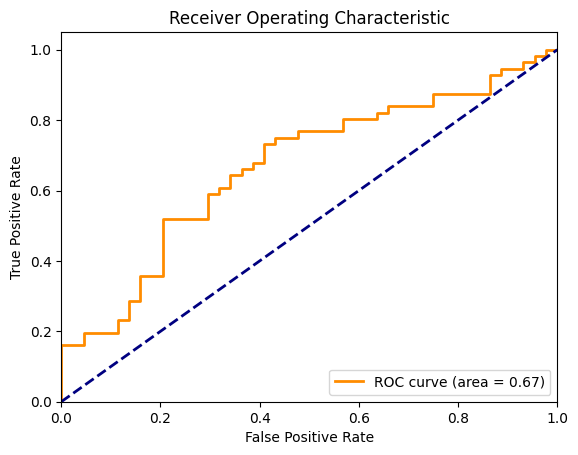

Final Accuracy: 0.57
Final Loss: 0.9587935058398633


In [11]:
import numpy as np
import pennylane as qml
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

n_qubits = 4  # Number of qubits used for quantum-enabled devices
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum layer as a QNode compatible with NumPy
@qml.qnode(dev, interface="numpy")
def quantum_layer(params, data):
    # Encode classical data as quantum states
    for i in range(len(data)):
        qml.RY(data[i], wires=i)

    # Apply parameterized rotations for optimization
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)

    # Measure the expectation values and return as a numpy array
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the Quantum Federated Learning model with an optional quantum layer
class QFLModel:
    def __init__(self, use_quantum=False):
        self.use_quantum = use_quantum
        self.params = np.random.normal(size=n_qubits)  # Model parameters (e.g., weights)

    def forward(self, x):
        if self.use_quantum:
            # Apply quantum layer and return result
            return quantum_layer(self.params, x)
        else:
            # Simulate a basic classical forward pass (e.g., simple linear function)
            return np.dot(self.params, x)

    def train_on_batch(self, X, y, learning_rate=0.01):
        # Simple gradient descent update rule for simulated training
        for i in range(len(X)):
            prediction = self.forward(X[i])
            error = prediction - y[i]
            # Update parameters (gradient step)
            self.params -= learning_rate * error * X[i]

# Federated Learning setup with client models
num_clients = 5
quantum_clients = [0, 1]  # Assign first two clients as quantum-enabled devices

# Create models for each client (quantum-enabled or classical)
clients = [QFLModel(use_quantum=(i in quantum_clients)) for i in range(num_clients)]

# Generate synthetic data for training
X_train = np.random.uniform(-1, 1, (100, n_qubits)).astype(np.float64)
y_train = np.random.randint(0, 2, (100,)).astype(np.float64)

# Initialize global model
global_model = QFLModel()

# Define federated training round
def federated_training_round():
    client_params = []

    # Local training on each client
    for client in clients:
        client.train_on_batch(X_train, y_train)
        # Collect each client's parameters after training
        client_params.append(client.params)

    # Aggregate weights by averaging across clients
    new_global_params = np.mean(client_params, axis=0)
    global_model.params = new_global_params

    # Update each client's parameters to the new global parameters
    for client in clients:
        client.params = new_global_params.copy()
# Lists to store accuracy and loss for each round
accuracy_list = []
loss_list = []

# Federated learning process
num_rounds = 25
for round in range(num_rounds):
    federated_training_round()

    # Evaluate current global model and calculate accuracy
    correct_predictions = 0
    for i in range(len(X_train)):
        prediction = 1 if global_model.forward(X_train[i]) > 0.5 else 0
        correct_predictions += int(prediction == y_train[i])
    accuracy = correct_predictions / len(X_train)
    accuracy_list.append(accuracy)

    # Calculate loss (e.g., mean squared error)
    predictions = [global_model.forward(x) for x in X_train]
    loss = np.mean((predictions - y_train) ** 2)
    loss_list.append(loss)

# Plot accuracy and loss over rounds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_rounds + 1), accuracy_list)
plt.xlabel("Federated Round")
plt.ylabel("Accuracy")
plt.title("Accuracy over Federated Rounds")

plt.subplot(1, 2, 2)
plt.plot(range(1, num_rounds + 1), loss_list)
plt.xlabel("Federated Round")
plt.ylabel("Loss")
plt.title("Loss over Federated Rounds")

plt.tight_layout()
plt.show()

# Evaluate final global model and calculate ROC curve
y_true = y_train
y_scores = [global_model.forward(x) for x in X_train]

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"Final Accuracy: {accuracy_list[-1]}")
print(f"Final Loss: {loss_list[-1]}")